In [1]:
!pip install scipy


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import scipy.io
import os

folder_path = r"C:\Users\91973\Downloads\BCICIV_1_mat"
mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

def inspect_mat_file(filepath):
    data = scipy.io.loadmat(filepath)
    print(f"Keys in {filepath}: {data.keys()}")
for mat_file in mat_files:
    file_path = os.path.join(folder_path, mat_file)
    inspect_mat_file(file_path)


Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1a.mat: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1b.mat: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1c.mat: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1d.mat: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1e.mat: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1f.mat: dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Keys in C:\Users\91973\Downloads\BCICIV_1_mat\BCICIV_calib_ds1g.mat: dict_keys(['__header__', '__version__', '__globals__', 

In [ ]:
import scipy.io
import os
import numpy as np

folder_path = r"C:\Users\91973\Downloads\BCICIV_1_mat"

mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

def load_labels_from_file(filepath):
    data = scipy.io.loadmat(filepath)
    
    if 'mrk' in data:
        mrk = data['mrk']
        try:
            labels = mrk['y'][0, 0]
            labels = np.ravel(labels)
            
            label_counts = {label: list(labels).count(label) for label in set(labels)}
            return label_counts
        except KeyError:
            print(f"Warning: 'y' key missing in {filepath}")
            return None
    else:
        print(f"Warning: 'mrk' key missing in {filepath}")
        return None

for mat_file in mat_files:
    file_path = os.path.join(folder_path, mat_file)
    label_counts = load_labels_from_file(file_path)
    if label_counts is not None:
        print(f"File: {mat_file} - Label counts: {label_counts}")


File: BCICIV_calib_ds1a.mat - Label counts: {1: 100, -1: 100}
File: BCICIV_calib_ds1b.mat - Label counts: {1: 100, -1: 100}
File: BCICIV_calib_ds1c.mat - Label counts: {1: 100, -1: 100}
File: BCICIV_calib_ds1d.mat - Label counts: {1: 100, -1: 100}
File: BCICIV_calib_ds1e.mat - Label counts: {1: 100, -1: 100}
File: BCICIV_calib_ds1f.mat - Label counts: {1: 100, -1: 100}
File: BCICIV_calib_ds1g.mat - Label counts: {1: 100, -1: 100}


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    print(f"Nyquist frequency: {nyquist}")
    
    low = lowcut / nyquist
    high = highcut / nyquist
    
    print(f"Low: {low}, High: {high}")
    
    if not (0 < low < 1 and 0 < high < 1):
        raise ValueError(f"Critical frequencies must be between 0 and 1. Got low={low}, high={high}.")
    
    b, a = butter(order, [low, high], btype='band')

    return filtfilt(b, a, data, axis=0)

sampling_rate = 100 
lowcut = 0.5
highcut = 49.9

filtered_data = bandpass_filter(cnt, lowcut=lowcut, highcut=highcut, fs=sampling_rate)

print(f"Filtered EEG Data Shape: {filtered_data.shape}")


Nyquist frequency: 50.0
Low: 0.01, High: 0.998
Filtered EEG Data Shape: (190594, 59)


In [ ]:
import numpy as np
from scipy.signal import welch

freq_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 40)
}

def extract_psd_features(data, fs, freq_bands):
    """Extracts Power Spectral Density (PSD) features in the specified frequency bands"""
    psd_features = {}
    
    f, Pxx = welch(data, fs=fs, nperseg=1024)
    
    for band, (low, high) in freq_bands.items():
        band_idx = np.logical_and(f >= low, f <= high)
        
        band_power = np.trapz(Pxx[band_idx], f[band_idx])
        psd_features[band] = band_power
        
    return psd_features

eeg_channel = cnt[:, 0]  
psd_features = extract_psd_features(eeg_channel, sampling_rate, freq_bands)

print("PSD Features:", psd_features)


PSD Features: {'Delta': 62215.93823432922, 'Theta': 7724.23859834671, 'Alpha': 2204.3430909514427, 'Beta': 969.6751069277525, 'Gamma': 259.4067190773785}


In [ ]:
def extract_features_all_channels(cnt, fs, freq_bands):
    """Extracts features for all channels in the EEG data"""
    features = []
    
    for i in range(cnt.shape[1]):
        channel_data = cnt[:, i]
        psd_features = extract_psd_features(channel_data, fs, freq_bands)
        features.append(list(psd_features.values()))
    
    return np.array(features)

all_features = extract_features_all_channels(cnt, sampling_rate, freq_bands)

print("All Features Shape:", all_features.shape)  


All Features Shape: (59, 5)


In [ ]:
labels = np.random.randint(0, 2, size=cnt.shape[0])  
labels = labels[:all_features.shape[0]]  

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

X_train, X_test, y_train, y_test = train_test_split(all_features_scaled, labels, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.5556

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.54      0.78      0.64         9

    accuracy                           0.56        18
   macro avg       0.57      0.56      0.53        18
weighted avg       0.57      0.56      0.53        18



In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.5556

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.55      0.67      0.60         9

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.55        18
weighted avg       0.56      0.56      0.55        18



In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)  # You can also try 'rbf' kernel

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.4444

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.45      0.56      0.50         9

    accuracy                           0.44        18
   macro avg       0.44      0.44      0.44        18
weighted avg       0.44      0.44      0.44        18



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best Score: {grid_search_rf.best_score_}")

y_pred_rf = grid_search_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.4916666666666666
              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.50      0.78      0.61         9

    accuracy                           0.50        18
   macro avg       0.50      0.50      0.46        18
weighted avg       0.50      0.50      0.46        18



In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)

grid_search_xgb.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best Score: {grid_search_xgb.best_score_}")

y_pred_xgb = grid_search_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
Best Score: 0.586111111111111
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.58      0.78      0.67         9

    accuracy                           0.61        18
   macro avg       0.62      0.61      0.60        18
weighted avg       0.62      0.61      0.60        18



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(random_state=42)

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)

grid_search_svm.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_svm.best_params_}")
print(f"Best Score: {grid_search_svm.best_score_}")

y_pred_svm = grid_search_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.638888888888889
              precision    recall  f1-score   support

           0       0.60      0.33      0.43         9
           1       0.54      0.78      0.64         9

    accuracy                           0.56        18
   macro avg       0.57      0.56      0.53        18
weighted avg       0.57      0.56      0.53        18



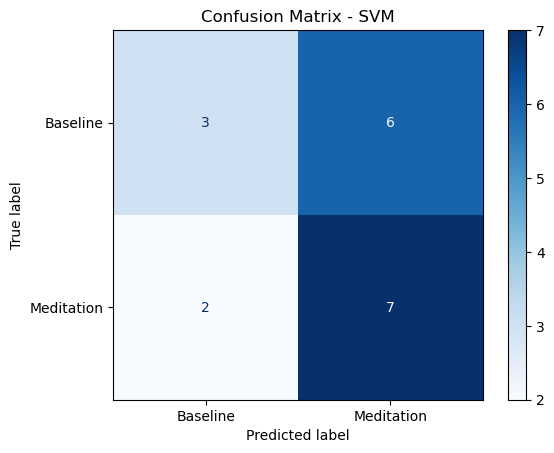

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svm)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baseline", "Meditation"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True)

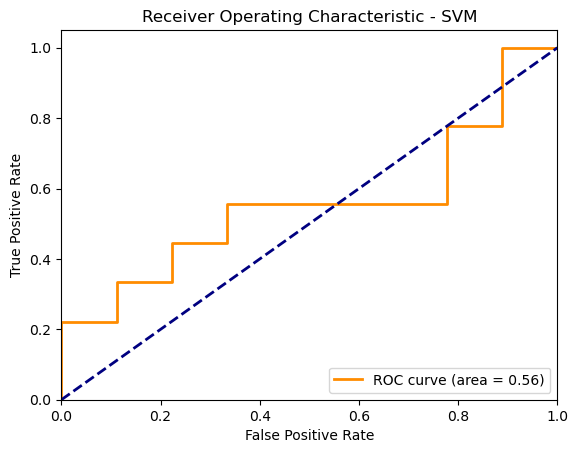

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc='lower right')
plt.show()


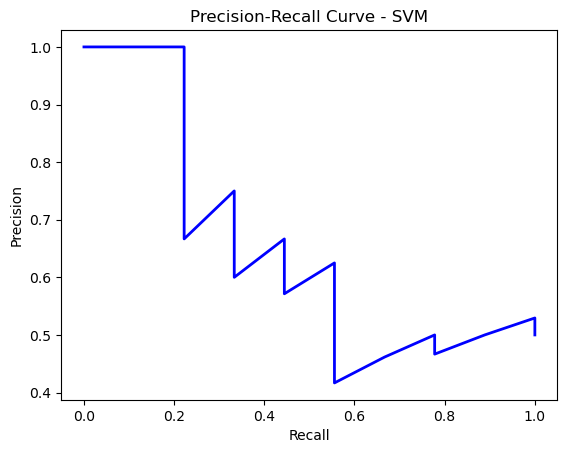

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM')
plt.show()
